In [2]:
import os
import torch
import numpy as np
import pandas as pd
from PIL import Image
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

AttributeError: module 'pandas' has no attribute 'core'

In [123]:
def rle_encode(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = img.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)
 
def rle_decode(mask_rle, shape):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape)

In [179]:
class TGSDataset(Dataset):
    def __init__(self, csv_file, image_dir):
        self.input = pd.read_csv(csv_file)
        self.input.dropna(inplace=True)
        self.image_dir = image_dir

    def __len__(self):
        return len(self.input)

    def __getitem__(self, idx):
        img_name = os.path.join(self.image_dir,self.input.iloc[idx, 0]+'.png')
        image = np.array(Image.open(img_name)).reshape(3,101,101)
        image = image/255
        target = rle_decode(self.input.iloc[idx,1],(101,101))
        return image,target

In [180]:
train_dataset = TGSDataset("TGS_Dataset/train.csv","TGS_Dataset/train/images/")

In [181]:
batch_size = 200
validation_split = 0.3
shuffle_dataset = True
random_seed= 42
# Creating data indices for training and validation splits:
dataset_size = len(train_dataset)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
validation_sampler = SubsetRandomSampler(val_indices)
train_loader = torch.utils.data.DataLoader(train_dataset,batch_size=batch_size,sampler=train_sampler)
validation_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,sampler=validation_sampler)

In [187]:
class TGSModel(nn.Module):
    def __init__(self,upscale_factor=101):
        super(TGSModel,self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 64, (5, 5), (1, 1), (2, 2)),
            nn.ReLU())
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 64, (3, 3), (1, 1), (1, 1)),
            nn.ReLU())
        
        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 32, (3, 3), (1, 1), (1, 1)),
            nn.ReLU())
        
        self.layer4 = nn.Sequential(
            nn.Conv2d(32, upscale_factor ** 2, (3, 3), (1, 1), (1, 1)),
            nn.PixelShuffle(upscale_factor))
        
    def forward(self,x):
        output=self.layer1(x)
        output=self.layer2(output)
        output=self.layer3(output)
        output=self.layer4(output)
        return output

In [195]:
model=TGSModel()
model.double()
criterion = nn.MultiLabelMarginLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
if torch.cuda.is_available():
    model = model.cuda()
    criterion = criterion.cuda()

In [196]:
# for batch_idx, (data, target) in enumerate(train_loader):
#     data, target = Variable(data), Variable(target)
#     data=data.double()
#     print(data.dtype)
#     optimizer.zero_grad()
output = model(data)

torch.float64


RuntimeError: Expected object of type torch.DoubleTensor but found type torch.cuda.DoubleTensor for argument #2 'weight'

In [ ]:
def train():
    epoch=1
    prev_accu=0
    count=0
    while True:
        total_loss=0
        model.train()
        exp_lr_scheduler.step()
        print(exp_lr_scheduler.get_lr())
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = Variable(data), Variable(target)
            if torch.cuda.is_available():
                data = data.cuda()
                target=target.long()
                target = target.cuda()
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            total_loss+=loss.data[0]
            if (batch_idx + 1)% 10 == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.5f}'.format(epoch, (batch_idx + 1) * len(data), len(train_indices),100*(batch_idx + 1)* len(data) / len(train_indices), loss.data[0]))
        print('AVG Loss: {:.5f}'.format(total_loss*batch_size/len(train_indices)))
        accu=evaluate(epoch,exp_lr_scheduler.get_lr())
        if prev_accu>accu:
            count+=1
        else:
            if accu>90:
                filename='%s_%.2f.pt'%(epoch,accu)
                torch.save(model,filename)
            count=0
        if count==5:
            break
        prev_accu=accu
        epoch+=1

In [173]:
ps = nn.PixelShuffle(3)
input = torch.autograd.Variable(torch.Tensor(1,9 , 4, 4))
output = ps(input)
print(output.size())
torch.Size([1, 1, 12, 12])

torch.Size([1, 1, 12, 12])


torch.Size([1, 1, 12, 12])

In [148]:
img=Image.open("TGS_Dataset/train/images/00a3af90ab.png")

In [158]:
n=np.array(img)

In [174]:
n/255

array([[[ 0.54509804,  0.54509804,  0.54509804],
        [ 0.53333333,  0.53333333,  0.53333333],
        [ 0.53333333,  0.53333333,  0.53333333],
        ..., 
        [ 0.49411765,  0.49411765,  0.49411765],
        [ 0.48235294,  0.48235294,  0.48235294],
        [ 0.4627451 ,  0.4627451 ,  0.4627451 ]],

       [[ 0.54117647,  0.54117647,  0.54117647],
        [ 0.54901961,  0.54901961,  0.54901961],
        [ 0.54901961,  0.54901961,  0.54901961],
        ..., 
        [ 0.49803922,  0.49803922,  0.49803922],
        [ 0.4627451 ,  0.4627451 ,  0.4627451 ],
        [ 0.43137255,  0.43137255,  0.43137255]],

       [[ 0.55686275,  0.55686275,  0.55686275],
        [ 0.54901961,  0.54901961,  0.54901961],
        [ 0.54117647,  0.54117647,  0.54117647],
        ..., 
        [ 0.5254902 ,  0.5254902 ,  0.5254902 ],
        [ 0.50588235,  0.50588235,  0.50588235],
        [ 0.49019608,  0.49019608,  0.49019608]],

       ..., 
       [[ 0.6       ,  0.6       ,  0.6       ],
        

In [163]:
n[0,0]

array([139, 139, 139], dtype=uint8)

In [160]:
p=n.reshape(3,101,101)

In [165]:
p[:,0,0]

array([139, 116, 139], dtype=uint8)

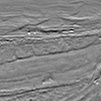

In [178]:
Image.fromarray(n)